# CPSC 340, Fall 2021

CNN details bonus lecture

Outline:

- 1D signals 
- 1D convnets: `Conv1D` layer
- 1D convnets: implementation (skip?)
- 1D convnets: pooling with `MaxPooling1D`
- 1D convnets: flattening with `Flatten` 
- 1D convnets: end-to-end example
- 1D convnets: strided convolutions and padding (skip?)
- 2D convnets 

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model, clone_model

import numpy as np
import pandas as pd
import scipy.signal
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['font.size'] = 16

## 1D signals (5 min)

#### 1D signals with multiple features

- Let's say that the sequences are stepping over time. E.g. temperature each day in Vancouver.
- Well, what if we measure more than just temperature, e.g. wind speed, rainfall, etc.
- We might get a _vector of measurements_, or in other words a _vector of features_, every day.

| Day | Temp | Wind speed | Rainfall |
|-----|-----|---------------|-------|
|  1   | 20  | 0           |   0 |
|  2   | 10  |  5           | 4  |
|  3    | 12  | 6          |  4 |
|  4    |  12 |  1         |  0 |
| ...  | ...  | ... | ... |

We can encode this as

In [3]:
day1 = [20,0,0]
day2 = [10,5,4]
day3 = [12,6,4]
day4 = [12,1,0]

In [4]:
x = np.vstack((day1,day2,day3,day4))
x

array([[20,  0,  0],
       [10,  5,  4],
       [12,  6,  4],
       [12,  1,  0]])

- You can think of this as 3 sequences (temp sequence, wind speed sequence, rainfall sequence), or as one sequence of 3D vectors. 
  - For today, let's go with the latter.
- This means _each training example is a sequence of vectors or, in other words, a 2D array_
  - This is a big departure from what we're used to, where each training example is a vector (1D array).
- Now, if we want to store our entire dataset in one variable, it's a 3D array: (number of training examples) $\times$ (number of steps in sequence) $\times$ (number of features). Before, $X$ was just 2D, with dimensions $n \times d$. Let's use $T$ to denote the number of steps. So then $X$ is $n \times T \times d$.

In [5]:
# df = pd.DataFrame({'Temp': [20,10,12,12], 'Wind-speed': [0,5,6,1], 'Rainfal': [0,4,4,0]})
# df.index.name="Day"
# df

## 1D convnets: `Conv1D` layer (15 min)

High level overview: a `Conv1D` layer transforms an example (roughly) from $T \times d_0$ to $T \times d_1$. This is like a `Dense` layer (from $d_0$ to $d_1$), but with this extra $T$ dimension along for the ride.

Important point: with CNNs, **the filters are the paramameters we're learning** (aka weights).

- In a 1D convolutional layer, you have some number of filters (a hyperparameter).
- Each filter has a size (a hyperparameter), which is the same for all filters in the layer.

Example: 5 filters, each of size 3. The signals are of length 100 with 1 feature. **We're going from 1 feature to 5 features.**

In symbols, $d_0=1$, $d_1=5$, $T=100$, and $k_0=3$ (let's use $k$ to denote the filter sizes).


In [6]:
model = Sequential()
model.add(Conv1D(5, kernel_size=3, input_shape=(100,1), padding='same'))
#                ^d_1           ^k_0            ^T  ^d_0 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 5)            20        
                                                                 
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.get_weights()[0].shape

(3, 1, 5)

In [8]:
model.get_weights()[0][:,0,:].T

array([[ 0.35247046, -0.5715304 ,  0.259677  ],
       [ 0.27170825,  0.24326664, -0.18133032],
       [ 0.3463838 , -0.05434394,  0.3162728 ],
       [-0.48530507,  0.15681028,  0.32024592],
       [ 0.34160912, -0.56904894,  0.23156452]], dtype=float32)

Above: 5 filters, each of length 3. We don't have a 3rd dimension because there's only 1 input feature. (The values themselves are just random numbers.)

Let's use this to perform the convolutions.

In [9]:
x = np.sin(np.linspace(0,3,100)) + np.random.randn(100)*0.1

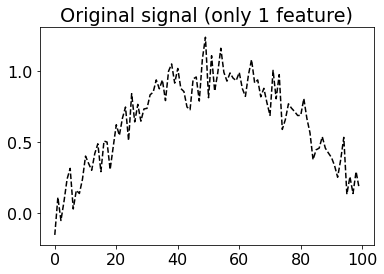

In [10]:
plt.plot(x, '--k');
plt.title("Original signal (only 1 feature)");

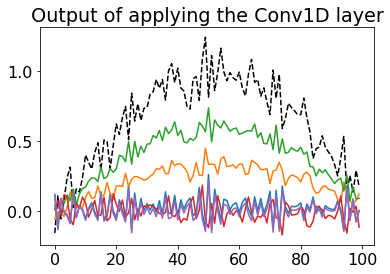

In [11]:
out_example = model.predict(x[None,:,None])
plt.plot(x, '--k');
plt.plot(out_example[0]);
plt.title("Output of applying the Conv1D layer");

Above: this is showing the original (black), and 5 different sequences resulting from convolutions of the original sequence with the 5 different length-3 filters.

- Ok, great, so that's what a convolutional layer does!
- (Below) you can also visualize the output as a heatmap.

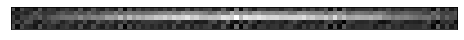

In [12]:
plt.figure(figsize=(8,8))
plt.imshow(out_example[0].T, cmap='gray');
plt.xticks(());
plt.yticks(());

In [13]:
out_example.shape

(1, 100, 5)

- Above: shape is $n \times T \times k_1$.
- These are the "activations" -- the circles in our circle/arrow diagram. 
- Again, we have one extra dimension compared to what we're used to.

Another example, with $d_0=2$.

In [14]:
model = Sequential()
model.add(Conv1D(5, kernel_size=3, input_shape=(100,2), padding='same'))
#                ^d_1           ^k_0            ^T  ^d_0 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 100, 5)            35        
                                                                 
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.get_weights()[0].shape

(3, 2, 5)

In [16]:
model.get_weights()[0]

array([[[-0.32394964,  0.31108862,  0.50161344, -0.18580216,
         -0.33224204],
        [ 0.31722808, -0.37583995, -0.03175539, -0.49961957,
          0.17903954]],

       [[-0.1146051 , -0.3518644 , -0.13092902,  0.38359696,
          0.34856546],
        [ 0.17725706,  0.22365111,  0.08388805,  0.20990527,
         -0.4704545 ]],

       [[ 0.0649181 ,  0.27509654, -0.16268554, -0.33896184,
          0.37761813],
        [ 0.28593582,  0.28472102, -0.4733241 , -0.18996334,
         -0.18109491]]], dtype=float32)

![](Conv1D.png)

- See the calculation of the number of parameters.
- Above, `model.summary()` told us we have 35 parameters, so this matches.

**Some key points here:** 

- Each "arrow" in our diagram is now a filter of length 3
- We are going from 2 features to 5 features
- Before, that would mean a $5\times 2$ matrix or 10 parameters (or $2\times 5$ in the convention Keras  uses)
- Now, it means a $3 \times 2\times 5$ matrix or 30 parameters because we have 10 arrows, each a length-3 filter.
  - Plus 5 biases; we still have one bias per "circle" in our diagram, except the input layer
  - Our weights live in a 3D array or "tensor", NOT a matrix.
  - (The biases are still in a vector, or 1D array.)
- In fully connected neural networks, a $5\times 2$ matrix "consumes" the length-2 dimension (by summing over it), and leaves you only with the length-5 dimension.
- The same thing happens here: the length-2 dimension was consumed, and a length-5 dimension appeared instead. The sequence dimension (length 100) comes along for the ride. 

In [17]:
x = np.random.rand(1,100,2) # n=1, T=100, d=2
x.shape

(1, 100, 2)

In [18]:
model.predict(x).shape

(1, 100, 5)

Another example: more training examples:

In [19]:
X = np.random.rand(1000,100,2)
X.shape

(1000, 100, 2)

$n=1000,T=100,d_0=2$

In [20]:
out = model.predict(X)
out.shape

(1000, 100, 5)

Note: to run with $n=1000$, **I did not need a new Keras model**. The architecture is the same, I just passed in multiple training examples.

Example: 2 layers

In [21]:
model = Sequential()
model.add(Conv1D(5, kernel_size=3, input_shape=(100,2), padding='same', activation='relu'))
#                ^d_1           ^k_0            ^T  ^d_0 

model.add(Conv1D(4, kernel_size=7, padding='same', activation='relu'))
#                ^d_2           ^k_1

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 100, 5)            35        
                                                                 
 conv1d_3 (Conv1D)           (None, 100, 4)            144       
                                                                 
Total params: 179
Trainable params: 179
Non-trainable params: 0
_________________________________________________________________


- Above: In general we want a nonlinear activation function applied at every layer.
- I sometimes skip it in this lecture, just to reduce the amount of code you're reading.

In [22]:
model.get_weights()[0].shape # 1st layer filters

(3, 2, 5)

In [23]:
model.get_weights()[1].shape # 1st layer biases

(5,)

In [24]:
model.get_weights()[2].shape # 2nd layer filters

(7, 5, 4)

In [25]:
model.get_weights()[3].shape # 2nd layer biases

(4,)

- See the $(3,2,5)$ and the $(7,5,4)$ 
  - It is not a coincidence that those 5's are the same number.
  - They are both $d_1$.

- Below: here is the circle/arrow diagram for this 2-layer network.
- Just like with fully-connected networks, the output of one layer becomes the input of the next layer.

![](Conv1D_2layers.png)

- Again, we can account for the 179 parameters.
- Here, I am drawing the relu to show that it's transforming sequences.

### 1D convnets: implementation (optional)

- Below are some numpy implementations _of a single layer_.
- We'll ignore biases and activation functions; this is just the linear step.
- We'll show several implementations for FCN (fully connected network) and the CNN.

In [26]:
W = np.random.randn(5,2)
x = np.random.rand(2)

In [27]:
def FCN_layer(W, x):
    return W@x

FCN_layer(W,x)

array([0.10751442, 0.79994873, 0.66273793, 0.04988529, 0.41674472])

In [28]:
def FCN_layer_loop(W, x):
    out_dim, in_dim = W.shape # get the shapes
    out = np.zeros(out_dim)   # initialize the output vector
    for i in range(out_dim):  # loop through each output circle in our circle/arrow diagram
        out[i] = W[i]@x       # dot product between x and a row of W 
    return out

FCN_layer_loop(W,x)

array([0.10751442, 0.79994873, 0.66273793, 0.04988529, 0.41674472])

In [29]:
def FCN_layer_loop_full(W, x):
    out_dim, in_dim = W.shape # get the shapes
    out = np.zeros(out_dim)   # initialize the output vector
    for i in range(out_dim):  # loop through each output circle in our circle/arrow diagram
        for j in range(in_dim):  # loop through each input circle in our circle/arrow diagram
            out[i] += W[i,j]*x[j]  # multiply x[j] and W[i,j]; this is an arrow in our circle/arrow diagram
    return out


FCN_layer_loop_full(W,x)

array([0.10751442, 0.79994873, 0.66273793, 0.04988529, 0.41674472])

In [30]:
model = Sequential()
model.add(Dense(5, input_dim=2))
model.set_weights((W.T, np.zeros(5)))
model.predict(x[None])[0]

array([0.10751441, 0.79994875, 0.6627379 , 0.04988529, 0.41674474],
      dtype=float32)

- Bam!
- The point of the above is to break down the neural network into its most basic operations, multiplication and addition.
- To me, the first two are more intuitive, and the last one is a bit confusing.
- Now let's do that with a CNN, but in the opposite order (fully looped first).
  - Well, actually there is a version with 3 loops (not shown) where the convolution is expressed as a loop as well.
- Again, this is just one layer, not a full network.

In [31]:
W = np.random.rand(3,5,2) # k x d_1 x d_0
x = np.random.rand(10,2)  # T x d_0

In [32]:
def CNN_layer_loop_full(W,x):
    filter_size, out_dim, in_dim = W.shape
    T = x.shape[0]
    T = T - filter_size + 1 # boundary stuff
    
    W_flip = W[::-1] # flip the filters to correspond with how Keras does things (no flipping)

    out = np.zeros((T, out_dim))
    for i in range(out_dim):
        for j in range(in_dim):
            out[:,i] += scipy.signal.convolve(x[:,j],W_flip[:,i,j], mode='valid')
    
    return out

CNN_layer_loop_full(W,x)

array([[1.64539516, 0.72070454, 1.36617543, 0.48131061, 1.50002222],
       [2.24968521, 0.99128001, 1.45834548, 0.89026653, 2.06124492],
       [2.27558294, 1.29468622, 1.74090511, 1.18974793, 2.22719487],
       [1.82324582, 1.20957762, 1.665221  , 0.97399985, 1.93737249],
       [1.88903022, 0.8515436 , 1.34333422, 0.70452121, 1.59953027],
       [1.70736972, 0.95532984, 1.26372821, 0.88481213, 1.81673166],
       [1.6237069 , 1.07282939, 1.4148344 , 0.82121318, 1.72156379],
       [1.66993366, 0.65308261, 0.94158794, 0.61266692, 1.37298965]])

Below: a Conv1D layer can also be implemented cleverly with a 2D convolution, but this is more likely to confuse than to be helpful...

In [33]:
# WARNING: potentially confusing, read at your own risk!
# It's quite elegant that one can do this with a single loop though.
def CNN_layer_loop(W,x):
    filter_size, out_dim, in_dim = W.shape
    T = x.shape[0]
    T = T - filter_size + 1 # boundary stuff
    
    W_flip = W[::-1,:,::-1] # flip the filters to correspond with how Keras does things (no flipping)

    out = np.zeros((T, out_dim))
    for i in range(out_dim):
        out[:,i] = scipy.signal.convolve2d(x,W_flip[:,i,:], mode='valid')[:,0] 
    return out

CNN_layer_loop(W,x)

array([[1.64539516, 0.72070454, 1.36617543, 0.48131061, 1.50002222],
       [2.24968521, 0.99128001, 1.45834548, 0.89026653, 2.06124492],
       [2.27558294, 1.29468622, 1.74090511, 1.18974793, 2.22719487],
       [1.82324582, 1.20957762, 1.665221  , 0.97399985, 1.93737249],
       [1.88903022, 0.8515436 , 1.34333422, 0.70452121, 1.59953027],
       [1.70736972, 0.95532984, 1.26372821, 0.88481213, 1.81673166],
       [1.6237069 , 1.07282939, 1.4148344 , 0.82121318, 1.72156379],
       [1.66993366, 0.65308261, 0.94158794, 0.61266692, 1.37298965]])

In [34]:
model = Sequential()
model.add(Conv1D(5, kernel_size=3, input_shape=(10,2)))
model.set_weights((np.swapaxes(W,1,2), np.zeros(5)))
model.predict(x[None])[0]

array([[1.6453952 , 0.72070456, 1.3661754 , 0.4813106 , 1.5000222 ],
       [2.2496853 , 0.99128   , 1.4583455 , 0.89026654, 2.061245  ],
       [2.2755828 , 1.2946863 , 1.740905  , 1.1897479 , 2.2271948 ],
       [1.8232459 , 1.2095777 , 1.665221  , 0.9739998 , 1.9373724 ],
       [1.8890302 , 0.8515436 , 1.3433342 , 0.7045212 , 1.5995302 ],
       [1.7073696 , 0.9553298 , 1.2637281 , 0.8848121 , 1.8167317 ],
       [1.6237069 , 1.0728295 , 1.4148345 , 0.8212132 , 1.7215638 ],
       [1.6699336 , 0.6530826 , 0.941588  , 0.6126669 , 1.3729897 ]],
      dtype=float32)

- Above: we get the same results with a Keras `Conv1D` layer. 
- So from the above you can see what this layer is doing.
- The most useful comparison is probably `FCN_layer_loop_full` and `CNN_layer_loop_full`.
  - FCN inner loop: **an activation (number) multiplied by a weight (number)** .
  - CNN inner loop: **a signal (array) convolved with a filter (array)**.
  - The rest of the code is basically the same.
- This exercise could be easily extended to a `Conv2D` layer - if you're bored, give it a try!

### 1D convnets: pooling with `MaxPooling1D` (5 min)

In [35]:
model = Sequential()
model.add(Conv1D(5, kernel_size=3, input_shape=(100,2), padding='same'))
#                ^d_1           ^k_0            ^T  ^d_0 
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 100, 5)            35        
                                                                 
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


In [36]:
x = np.random.rand(1,100,2) # n=1, T=100, d=2
x.shape

(1, 100, 2)

In [37]:
out = model.predict(x)
out.shape

(1, 100, 5)

In [38]:
model = Sequential()
model.add(Conv1D(5, kernel_size=3, input_shape=(100,2), padding='same'))
#                ^d_1           ^k_0            ^T  ^d_0 

model.add(MaxPooling1D(pool_size=2))
#                                ^T is reduced by this factor, i.e. 100 to 50
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 100, 5)            35        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 5)            0         
 )                                                               
                                                                 
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


In [39]:
out = model.predict(x)
out.shape

(1, 50, 5)

Two observations:

1. Pooling does not introduce parameters
2. Pooling changes $T$, not $d$; this is the first time we changed $T$

![](Conv1D_and_MaxPooling1D.png)

The purpose of pooling:

- It is said to improve "translation invariance", which means that, say, the digit can be anywhere in the image.
- It helps to reduce the number of parameters (more on this below).

One other thing, about interpreting `model.summary()`: 

- We don't need to keep making an `out` variable, because the summary actually tells us this information. 
- The `None` dimension refers to the number of examples we're passing through at one time. 
  - Doesn't have to be the number of training examples.
  - With SGD this is the minibatch size.
  - At test time this is the number of test examples (maybe just one).
- To reiterate, this is a special dimension! It's not specified by the architecture.


### 1D convnets: flattening with `Flatten` (5 min)

- Eventually, we usually want to do some regression or classification.
- Say we'd doing 10-class classification of MNIST digits. Then we want to get from the current state (e.g. $50\times 5$) to just a vector of length 10.
- **We need to lose a whole dimension.**

In [40]:
x = np.random.rand(2,2)
x

array([[0.94511027, 0.42513265],
       [0.48051568, 0.96367119]])

In [41]:
x.flatten()

array([0.94511027, 0.42513265, 0.48051568, 0.96367119])

In [42]:
model = Sequential()
model.add(Conv1D(5, kernel_size=3, input_shape=(100,2), padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 100, 5)            35        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 50, 5)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 250)               0         
                                                                 
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


- Before, the output size was $n\times 50\times 5$ (see output shape of pool layer), now it's $n\times 250$. This is "flattening".
- It's unlikely that the number we get is exactly what we need (have 250, need 10), so it's common to include one (or more) `Dense` layers at the end.

#### Parameter flattening vs. data flattening

**Confusion warning**: We have discussed two types of flattening that are totally different.

1. Parameter flattening for optimization software: in neural networks, the parameters are spread across a bunch of matrices and vectors. We have to flatten the matrices and combine everything into one big flat vector. See lab 3 Exercise where you implemented `combine_params`. This is needed for regular (`Dense`) neural nets and has nothing to do with CNNs specifically.
2. Data flattening: 
  - "Visible" data flattening: When using regular (`Dense`) neural networks for images, we have to flatten the images into vectors. This is because the `Dense` layer takes in a 1D feature vector.
  - "Hidden" data flattening: **This is the one we just did with a `Flatten` layer**. Here, we are flattening the hidden values, not the original features, but it's for the same reason: we are feeding into a `Dense` layer and it expects a 1D input. This type of flattening (of hidden values) is _not_ needed in regular neural nets but is needed with CNNs.

This is confusing but important - you may need to review this more at home.

PS:

- A reminder that in lab3, when you flattened the images, the number of features came from the number of pixels.
- In CNNs the number of features explicitly does NOT depend on the number of pixels, but rather is just equivalent to the number of channels.

### 1D convnets: end-to-end example (5 min)

In [43]:
model = Sequential()
model.add(Conv1D(5, kernel_size=3, input_shape=(200,2), padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(7, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10)) # for 10-class classification
# one could add more Dense layers here
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 200, 5)            35        
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 100, 5)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5010      
                                                                 
Total params: 5,045
Trainable params: 5,045
Non-trainable params: 0
_________________________________________________________________


- Now the convnet is a mapping FROM sequences of length 100, with 2 features per step, TO length-10 vectors (class probabilities).
- Very confusing but very important point: 
  - The pooling reduced the number of parameters "downstream", at the final `Dense` layer.
  - It did not reduce the number of parameters in the layers immediately following it, because it only changed the sequence length.

For regression we'd just output a number instead:

In [44]:
model = Sequential()
model.add(Conv1D(5, kernel_size=3, input_shape=(100,2), padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(7, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1)) # for regression
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 100, 5)            35        
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 50, 5)            0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 250)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 251       
                                                                 
Total params: 286
Trainable params: 286
Non-trainable params: 0
_________________________________________________________________


In [45]:
x = np.random.rand(1,100,2) # n=1, T=100, d=2
x.shape

(1, 100, 2)

In [46]:
model.predict(x) # just a number

array([[-0.24619387]], dtype=float32)

### 1D convnets: strided convolutions (optional)

- This is a similar idea to pooling.
- Instead of "sliding" the filter over every pixel, you slide it over every 2nd or 3rd pixel.
- This is like deleting every 2nd or 3rd element of the output. 
- Example:

In [47]:
model = Sequential()
model.add(Conv1D(5, kernel_size=3, input_shape=(100,2), padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 100, 5)            35        
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 50, 5)            0         
 1D)                                                             
                                                                 
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


In [48]:
model = Sequential()
model.add(Conv1D(5, kernel_size=3, strides=2, input_shape=(100,2), padding='same'))
#                                          ^ go every 2nd entry
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 50, 5)             35        
                                                                 
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


- Note the output shape is the same, so the architecture is extremely similar. 
- The results would not be identical though (for the same filters!), because with MaxPooling we're taking the max of every 2 outputs, instead of just keeping only the first one. With the right choice of filters, they might end up the same, which essentially makes the architectures equivalent.
- The pros/cons of these two approaches are not super clear to me. 

### 1D convnets: padding (optional)

Aside: if you're wondering why I'm setting `padding='same'` it's because of the boundary issues with convolutions. The default is to only include cases where the filter fully fits on top of the signal, meaning the actual output size is $T - k+1$. But that makes it more confusing when explaining what's going on, becuase the number keeps changing. 

In [49]:
model = Sequential()
model.add(Conv1D(5, kernel_size=3, input_shape=(100,2)))
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 98, 5)             35        
                                                                 
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


Above: output size is $98 \times 5$ instead of $100\times 5$

In [50]:
model = Sequential()
model.add(Conv1D(5, kernel_size=3, input_shape=(100,2)))
model.add(Conv1D(7, kernel_size=3))
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 98, 5)             35        
                                                                 
 conv1d_14 (Conv1D)          (None, 96, 7)             112       
                                                                 
Total params: 147
Trainable params: 147
Non-trainable params: 0
_________________________________________________________________


Above: each convolutional layer reduces the output size by $k-1$.

In [51]:
model = Sequential()
model.add(Conv1D(5, kernel_size=3, input_shape=(100,2)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(7, kernel_size=3))
model.add(MaxPooling1D(pool_size=2))
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 98, 5)             35        
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 49, 5)            0         
 1D)                                                             
                                                                 
 conv1d_16 (Conv1D)          (None, 47, 7)             112       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 23, 7)            0         
 1D)                                                             
                                                                 
Total params: 147
Trainable params: 147
Non-trainable params: 0
_________________________________________________________________


Above: it starts to get confusing: we went from 100 to 23.

## 2D convnets (15 min)

#### 2D signals: images

- A 2D signal is typically called an _image_.
- Here is one:

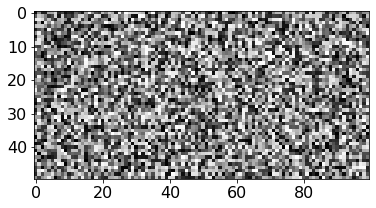

In [52]:
x = np.random.rand(50,100)
plt.imshow(x, cmap="gray");

- I will use $h$ and $w$ to denote the height and width; this is instead of $T$ for the 1D sequence length.
- The above image has size $h=50,w=100$.

#### Multiple channels

- As with the 1D case, you might have multiple features _per point in the signal_.
- A very common situation with images is to have 3 colour channels.
  - You saw this in DSCI 512 lab 4 (seam carving)

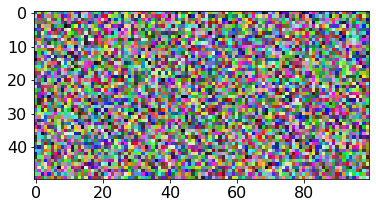

In [53]:
x = np.random.rand(50,100,3)
plt.imshow(x);

- In fact, _channel_ is the general term typically used here, rather than feature.
- I will continue using $d$ to denote the number of channels (aka features).
- The above image has size $h=50,w=100,d=3$.

In [55]:
test_img = plt.imread("snowy.jpg")
test_img.shape

(4000, 6000, 3)

- Above: 3 colour channels again.
- But 2D CNNs work with **any number of channels**. 
- In practice, another commonly occuring case is $d=1$ for grayscale images (e.g. electron microscope images, MNIST digits).

### 2D convnets: `Conv2D` layer

In [56]:
model = Sequential()
model.add(Conv2D(5, kernel_size=(11,11), input_shape=(test_img.shape[0],test_img.shape[1],3), padding='same', activation='sigmoid'))
#                ^d_1            ^k_0                 ^h                  ^w              ^d_0 
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 4000, 6000, 5)     1820      
                                                                 
Total params: 1,820
Trainable params: 1,820
Non-trainable params: 0
_________________________________________________________________


In [58]:
out = model.predict(test_img[None])
out.shape

(1, 4000, 6000, 5)

![](Conv2D.png)

- Critically, note that the number of parameters does not depend on the input image size (e.g. $50\times 100$).
- This is why the number of parameters is so much less than a fully connected network applied to a (visible data) flattened image.
- The number of parameters will eventually be affected by the input image size, but only after (hidden data) flattening.

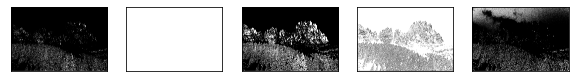

In [59]:
def make_plots(arr):
    num_plots = arr.shape[-1]
    plt.figure(figsize=(10,6))
    for i in range(num_plots):
        plt.subplot(1,num_plots,i+1);
        outimg = arr[:,:,i]
        plt.imshow((outimg-outimg.min())/(outimg.max()-outimg.min()), cmap='gray')
        plt.xticks(());
        plt.yticks(());

make_plots(out[0])

- What am I looking at here?
- Well, our output shape is $756 \times 506 \times 5$.
- With 1D convnets, our state was a 2D array, which we could draw either as a bunch of sequences or as an image... remember these?

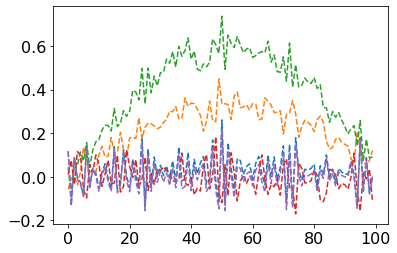

In [60]:
plt.plot(out_example[0], '--');

- Well, now we have an extra dimension. **So each channel is an image instead of a sequence**.
- In both cases we have 5 channels, but we visualize them differently.
- In each of the 5 images above, you're seeing random convolutions applied to each of the channels (which are then summed).
- In fact, we also could have separated out the _original_ image into its channels this way (though it would be weird to do so):

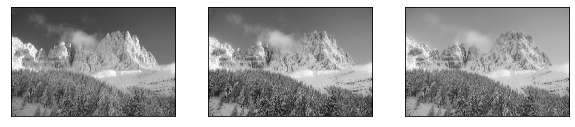

In [61]:
make_plots(test_img)

- Above: the red, green, and blue channels of the original milad image.
- Note that his shirt is "brighter" (more white) in the red channel because his shirt is pink.
- **It's important not to confuse these diagrams with having multiple examples; these are multiple channels for a single example.**

#### Warning: do not confuse the filters and the activations; both can be visualized!

- To make matters worse, the filters are now 2D and can also be visualized as images. 

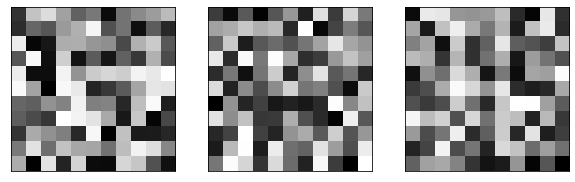

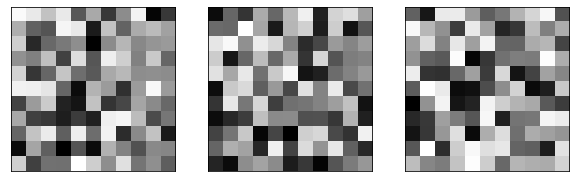

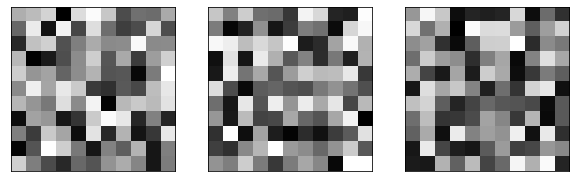

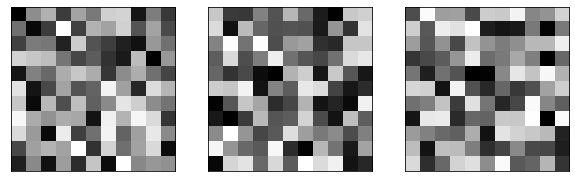

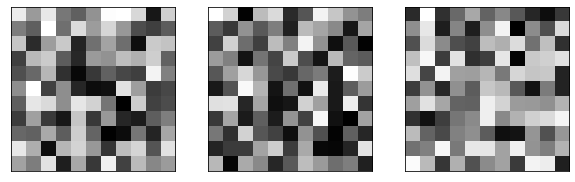

In [62]:
for i in range(5):
    make_plots(model.get_weights()[0][...,i])

- Above: these are the $3\times 5$ random $11\times 11$ filters currently in this `Conv2D` layer.
- This is like the $5 \times 3$ weight matrix from a fully connected network but
  - For 1D convnets, each entry (filter) is a 1D sequence
  - For 2D convnets, each entry (filter) is a 2D image
- Thus, the weight tensor is actually 4D.
- **These are the parameters that you learn with SGD**.

In [63]:
model.get_weights()[0].shape

(11, 11, 3, 5)

- This is (one reason) why people tend to get pretty confused...
- Plus, we have so many numbers to keep track of just for one layer: $d_0=3,d_1=5,k_0=(11,11),h=756,w=506$.
- For a FCN we'd only need the first two!

- Below: here is a schematic diagram of why we need 4 dimensions to represent the parameter tensor ($W$) for a `Conv2D` layer.
- The parameter filled in red is indexed by `W[2,4,0,1]`
- If you need 4 indices to address something, that means you have a 4D array.
- Note: in this case the filters are $3\times 3$ instead of $11\times 11$ to make drawing easier.

![](Conv2D_weight_tensor_4D.png)

And all this mess is only for one layer!

### 2D convnets: `MaxPooling2D`

In [65]:
model = Sequential()
model.add(Conv2D(5, kernel_size=(11,11), input_shape=test_img.shape, padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
#                                ^k is reduced by a factor of 2 in each direction
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 4000, 6000, 5)     1820      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2000, 3000, 5)    0         
 )                                                               
                                                                 
Total params: 1,820
Trainable params: 1,820
Non-trainable params: 0
_________________________________________________________________


Above: this does basically the exact same thing as 1D pooling, except that we are free to choose a separate pool factor for each dimension (but typically use the same one).

(optional) BTW it's valid syntax to just specify an integer if you want them all the same, i.e.

In [67]:
model = Sequential()
model.add(Conv2D(5, kernel_size=11, input_shape=test_img.shape, padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 4000, 6000, 5)     1820      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2000, 3000, 5)    0         
 2D)                                                             
                                                                 
Total params: 1,820
Trainable params: 1,820
Non-trainable params: 0
_________________________________________________________________


- The `11` implies `(11,11)` and the `2` implies `(2,2)`.
- However I suggest not doing this, as it's good to make sure you understand what's happening.
- E.g. going from `kernel_size=10` to `kernel_size=20` doesn't double the number of parameters in the layer, it quadruples it.

### 2D convnets: end-to-end example

- Below is an MNIST model.
- Note that here we don't set `padding='same'` (see optional section above about the padding)
  - This is why the convolution takes the size from $28\times 28$ to $24\times 24$.

In [68]:
mnist_model = Sequential()
mnist_model.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation='relu'))
mnist_model.add(MaxPooling2D(pool_size=(2, 2)))
mnist_model.add(Conv2D(50, (5, 5), activation='relu'))
mnist_model.add(MaxPooling2D(pool_size=(2, 2)))
mnist_model.add(Flatten())
mnist_model.add(Dense(128, activation='relu'))
mnist_model.add(Dense(10, activation='softmax'))

mnist_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 50)          40050     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 50)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 800)               0         
                                                                 
 dense_3 (Dense)             (None, 128)             

- This is the point where the image shape factors into the number of parameters:
  - The image shape is propagated through the layers.
  - Here, it's $28\times 28$, then $24\times 24$, then $12\times 12$; then, this gets flattened into $12\times12\times32=4608$ units.
  - The image shape right before the flattening determines the number of parameters of the first dense layer.
  - If we try changing the input shape, you'll see more parameters in the Dense layer, _not_ the Conv2D layer.


In [69]:
mnist_model = Sequential()
mnist_model.add(Conv2D(32, (5, 5), input_shape=(50, 50, 1), activation='relu'))
mnist_model.add(MaxPooling2D(pool_size=(2, 2)))
mnist_model.add(Conv2D(50, (5, 5), activation='relu'))
mnist_model.add(MaxPooling2D(pool_size=(2, 2)))
mnist_model.add(Flatten())
mnist_model.add(Dense(128, activation='relu'))
mnist_model.add(Dense(10, activation='softmax'))

mnist_model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 46, 46, 32)        832       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 19, 19, 50)        40050     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 9, 9, 50)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 4050)              0         
                                                                 
 dense_5 (Dense)             (None, 128)             

Summary of different types of networks:

| Layer type | Data shape $\quad \quad$ | Parameters shape $\quad \quad \quad \quad$ | Basic operation |
|--------|-------|-----|-----|
| `Dense` ("Conv0D") | $d_i$ (1D) | $d_i \times d_{i+1}$ (2D) | Multiplication ("0D convolution")|
| `Conv1D` | $T\times d_i$ (2D) | $k\times d_i \times  d_{i+1}$ (3D) | 1D convolution |
| `Conv2D` | $h \times w \times d_i$ (3D) | $k_h \times k_w \times d_i \times  d_{i+1}$ (4D) | 2D convolution |
| `Conv3D` | ${T\times h \times w \times d_i}$ (4D) | $k_T \times k_h \times k_w \times d_i \times  d_{i+1}$ (5D) | 3D convolution |

NOTES:

- I am nicknaming a fully connected (`Dense` in Keras) layers as "Conv0D" to emphasize the progression down the rows of the table, from fully connected to 1D CNN to 2D CNN to 3D CNN.
- The data shape is for **one** training example. In reality you'll have an other dimension at the start for the number of examples. Also, the data shape is for the data coming into the layer; replace $d_i$ with $d_{i+1}$ for the data coming out of the layer (and possibly reduce the other values due to boundary issues, pooling, etc.).
- The parameters shape is for **one** layer, and doesn't include the biases. 
- The basic operation is what happens at every arrow in the circle/arrow diagram, and is always followed by summation across the results from incoming arrows.
- $d_i$ is the number of features/channels in layer $i$
- $k$ is used for filter sizes
- $h$ and $w$ are height and width (of an image)
